In [1]:
import os, sys

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)

In [2]:
import importlib
import numpy as np
import torch
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from src.data.make_dataset import TextDetoxificationDataset, Evaluator

from src.models.train import BaselineTranslationModel

import torch.nn.functional as F

torch.manual_seed(0)
random.seed(0)
bleu_score = Evaluator.bleu_score

In [3]:
train_dataset = TextDetoxificationDataset(mode='train')
val_dataset = TextDetoxificationDataset(mode='val', vocab=train_dataset.vocab)
test_dataset = TextDetoxificationDataset(mode='test', vocab=train_dataset.vocab)

assert len(train_dataset.vocab) == 20081
assert train_dataset.vocab['this'] == 42

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mirak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2023-10-23 21:11:04.293 | INFO     | src.data.make_dataset:__init__:201 - Started building vocab


2023-10-23 21:12:11.820 | INFO     | src.data.make_dataset:__init__:208 - Vocab built successfully


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mirak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mirak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
model = BaselineTranslationModel(vocab=train_dataset.vocab, emb_dim=200, hidden_dim=200, n_layers=3)

Initializing with pretrained embeddings:   0%|          | 0/20081 [00:00<?, ?it/s]

C:\Users\mirak\PycharmProjects\TextDetoxification\src\models\train_model.py:44: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:212.)
  self.embeddings.weight.data[self.vocab[word]] = torch.Tensor(glove_model.get_vector(word))


In [5]:
with torch.no_grad():
    w1 = model.embeddings(torch.Tensor([model.vocab['king']]).long()).numpy().squeeze()
    w2 = model.embeddings(torch.Tensor([model.vocab['queen']]).long()).numpy().squeeze()
    w3 = model.embeddings(torch.Tensor([model.vocab['man']]).long()).numpy().squeeze()
    w4 = model.embeddings(torch.Tensor([model.vocab['woman']]).long()).numpy().squeeze()
    w5 = model.embeddings(torch.Tensor([model.vocab['carrot']]).long()).numpy().squeeze()
royal = w1 - w3
queen2queen = (royal + w4).T @ w2 / np.linalg.norm(royal + w4) / np.linalg.norm(w2)
queen2carrot = (royal + w4).T @ w5 / np.linalg.norm(royal + w4) / np.linalg.norm(w5)
print(queen2queen, queen2carrot)

0.65601796 0.19445348


In [6]:
# code taken from https://discuss.pytorch.org/t/pytorch-model-size-in-mbs/149002
size_model = 0
for param in model.parameters():
    if param.data.is_floating_point():
        size_model += param.numel() * torch.finfo(param.data.dtype).bits
    else:
        size_model += param.numel() * torch.iinfo(param.data.dtype).bits
print(f"model size: {size_model} bit | {size_model / 8e6:.2f} MB")

model size: 161320992 bit | 20.17 MB


### DataLoaders

In [7]:
def compute_loss(logits_seq, out):
    mask = out != model.vocab['<pad>'] # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.vocab)).to(torch.float32)

    # outputs of the model, [batch_size, out_len, num_tokens]
    # logits_seq = model(inp, out, **inference_params)

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    logprobs_seq = torch.log(logits_seq.softmax(dim=-1))

    # log-probabilities of correct outputs, [batch_size, out_len]
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1)

    # average cross-entropy over non-padding tokens
    return - torch.masked_select(logp_out, mask).mean() # average loss, scalar

In [8]:
def collate_batch(batch, max_len=64):
    source, target = [], []
    for src_sentence, tgt_sentence, _ in batch:
        source.append(torch.Tensor([train_dataset.BOS_IDX] + src_sentence[:max_len].tolist() + [train_dataset.EOS_IDX]).long())
        target.append(torch.Tensor([train_dataset.BOS_IDX] + tgt_sentence[:max_len].tolist() + [train_dataset.EOS_IDX]).long())
    
    source = torch.nn.utils.rnn.pad_sequence(source, batch_first=True, padding_value=train_dataset.PAD_IDX)
    target = torch.nn.utils.rnn.pad_sequence(target, batch_first=True, padding_value=train_dataset.PAD_IDX)

    return source.to(device), target.to(device)

In [9]:
batch_size = 32
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

In [10]:
# some santiy check
with torch.no_grad():
    model.to(device)
    for src, tgt in tqdm(train_loader):
        out = model(src, tgt)
        print(src.shape)
        print(tgt.shape)
        print(out.shape, len(train_dataset.vocab))
        loss = compute_loss(out, tgt)
        print(loss.item())
        break

  0%|          | 0/14445 [00:00<?, ?it/s]

torch.Size([32, 27])
torch.Size([32, 28])
torch.Size([32, 28, 20081]) 20081
12.055943489074707


In [12]:
# Overfit a single batch
batch = next(iter(train_loader))
dummy_model = BaselineTranslationModel(vocab=train_dataset.vocab, emb_dim=100, hidden_dim=100, n_layers=1).to(device)
optimizer = torch.optim.Adam(dummy_model.parameters(), lr=3e-4)
loss_fn = compute_loss
for i in range(1000):
    optimizer.zero_grad()
    out = dummy_model(src, tgt)
    loss = compute_loss(out, tgt)
    loss.backward()
    optimizer.step()
    if (i + 1) % 200 == 0:
        print(loss.item())

0.25459328293800354

0.016877496615052223

0.007169105112552643

0.004101733677089214

0.0026844909880310297


the model successfully overfit

### Training

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
epochs = 25
model.to(device);
bleu_score = Evaluator.bleu_score
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

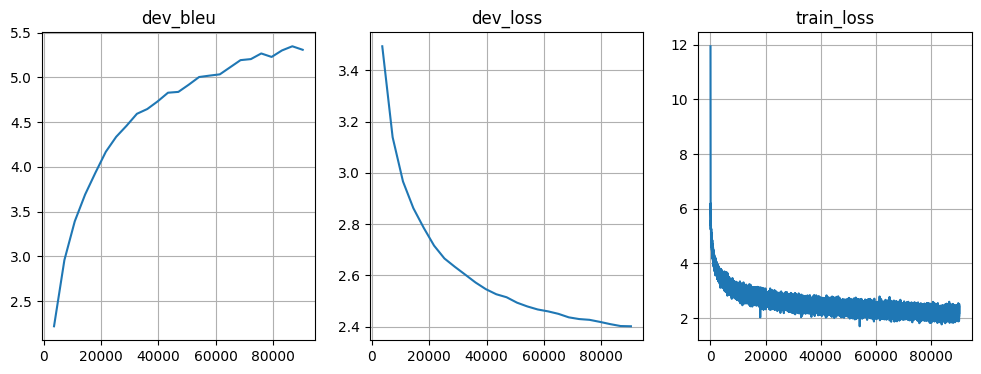

Mean loss=2.250

Best BLEU=5.347


In [15]:
from IPython.display import clear_output


metrics = {'train_loss': [], 'dev_bleu': [], 'dev_loss': []}  # 'dev_tox_drop': [], 'dev_sim': []}
best_bleu = 0.0
step = 0
for _ in tqdm(range(epochs)):
    for src, tgt in tqdm(train_loader, leave=False):
        step = len(metrics['train_loss']) + 1
        optimizer.zero_grad()
        loss = compute_loss(model(src, tgt), tgt)
        loss.backward()
        optimizer.step()
        scheduler.step()
        metrics['train_loss'].append((step, loss.item()))

    mean_bleu = 0
    # mean_similarity = 0
    # mean_toxicity_drop = 0
    mean_loss = 0
    # evaluator.toxicity_modmel.to(device); evaluator.similarity_model.to(device)
    for src, tgt in tqdm(val_loader, leave=False):
        with torch.no_grad():
            pred = model(src, tgt)
            loss = compute_loss(pred, tgt)
            pred = pred.argmax(-1).cpu().numpy()
            mean_bleu += np.sum([bleu_score(p, t) for p, t in zip(pred, tgt.cpu().numpy())])
            # pred_tokens = val_dataset.detokenize(pred)
            # src_tokens = val_dataset.detokenize(src)
            # mean_similarity += evaluator.estimate_similarity(pred_tokens, src_tokens).cpu().numpy().sum()
            # mean_toxicity_drop += (evaluator.estimate_toxicity(pred_tokens) - evaluator.estimate_toxicity(src_tokens)).sum()
            mean_loss += loss.item()
    metrics['dev_loss'].append((step, mean_loss / len(val_loader)))
    metrics['dev_bleu'].append((step, 100 * mean_bleu / len(val_dataset)))
    # metrics['dev_tox_drop'].append((step, mean_toxicity_drop / len(val_dataset)))
    # metrics['dev_sim'].append((step, mean_similarity / len(val_dataset)))
    # evaluator.toxicity_model.to('cpu'); evaluator.similarity_model.to('cpu')

    if best_bleu < metrics['dev_bleu'][-1][-1]:
        best_bleu = metrics['dev_bleu'][-1][-1]
        torch.save(model.state_dict(), '../models/rnn_best.pth')
    
    clear_output(True)
    plt.figure(figsize=(12,4))
    for i, (name, history) in enumerate(sorted(metrics.items())):
        plt.subplot(1, len(metrics), i + 1)
        plt.title(name)
        plt.plot(*zip(*history))
        plt.grid()
    plt.show()
    print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
    print("Best BLEU=%.3f" % best_bleu, flush=True)

### Evaluation on test set

In [20]:
model.load_state_dict(torch.load('/kaggle/input/rnn-ckpt/rnn_best.pth'))
print(device)
model.to(device)
model.eval()

cuda


BaselineTranslationModel(
  (vocab): Vocab()
  (embeddings): Embedding(20081, 200)
  (encoder): GRU(200, 200, num_layers=3, batch_first=True)
  (enc_dec_proj): Linear(in_features=200, out_features=200, bias=True)
  (decoder): GRUCell(200, 200)
  (vocab_projection): Linear(in_features=200, out_features=20081, bias=True)
)

In [21]:
evaluator = Evaluator()
evaluator.similarity_model.to(device)
evaluator.toxicity_model.to(device);

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [59]:
toxicity_drop = []
similarity = []

for i, (src, tgt) in tqdm(enumerate(test_loader), leave=False):
    with torch.no_grad():
        encoded = model.encode(src)
        pred, _ = model.decode_inference(encoded)
        pred_tokens = test_dataset.detokenize(pred)
        src_tokens = test_dataset.detokenize(src)
        if i % 50 == 0:
            print(src_tokens[0])
            print(pred_tokens[0])
            print('-' * 40)
        similarity.extend(evaluator.estimate_similarity(pred_tokens, src_tokens).cpu().numpy().reshape(-1))
        src_toxicity = evaluator.estimate_toxicity(src_tokens, probs=True)
        pred_toxicity = evaluator.estimate_toxicity(pred_tokens, probs=True)
        toxicity_drop.extend((src_toxicity - pred_toxicity).reshape(-1))

0it [00:00, ?it/s]

you got to rip all this shit out before jack sees it .
you have to pull out if it can jack .
----------------------------------------
i 'm glad i could make your delivery route more efficient , my <unk> prince of lies .
i 'm like , i can anticipate my best good data , i can also get drunk of the job .
----------------------------------------
if there 's more of them , lieutenant , they 'll kick our ass .
if they get among them , lieutenant would have come out of the south .
----------------------------------------
to the <unk> , we are ugly , so they become frightened .
the <unk> , we have defeated , they 're scared .
----------------------------------------
grab his legs .
grab his feet .
----------------------------------------
you know , he said it in like the fancy legal shit . but , but , yeah . he said people will protect their lives no matter what .
he said that that his strange opinion , but we 'd say there .
----------------------------------------
you want to spank me , do n'

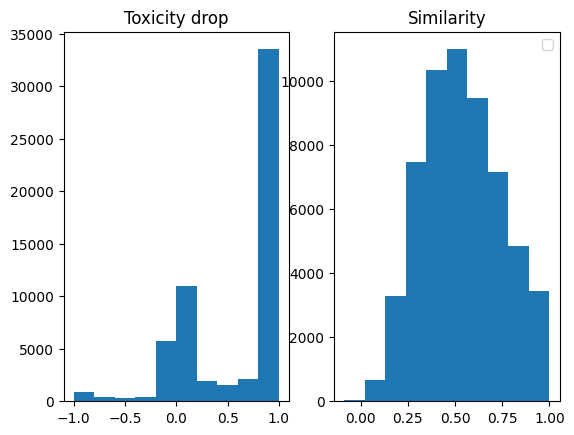

In [60]:
plt.subplot(121)
plt.hist(toxicity_drop)
plt.title('Toxicity drop')
plt.subplot(122)
plt.hist(similarity)
plt.title('Similarity');
plt.legend()
plt.show()

In [61]:
print(np.mean(toxicity_drop), np.std(toxicity_drop))

0.5983409 0.48755735


In [62]:
print(np.mean(similarity), np.std(similarity))

0.53899795 0.21021967


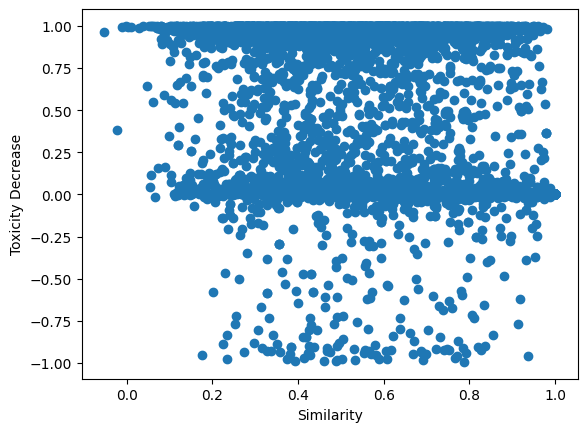

In [64]:
idx = np.random.randint(0, len(similarity), size=int(len(similarity) * 0.1))
plt.scatter(np.array(similarity)[idx], np.array(toxicity_drop)[idx])
plt.xlabel('Similarity') 
plt.ylabel('Toxicity Decrease');